2. 전이 학습으로 모델 성능 극대화하기

In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
BATCH_SIZE = 5

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭(좌우반전) 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭(상하반전) 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )      

train_generator = train_datagen.flow_from_directory(
       './data/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary') #이진분류

test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data/test',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [4]:
transfer_model = VGG16(weights='imagenet', 
                       include_top=False,    #top은 false인 상태로 가져옴
                       input_shape=(150, 150,3))
transfer_model.trainable = False
transfer_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [5]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64))
finetune_model.add(layers.Activation('relu'))
finetune_model.add(layers.Dropout(0.5))
finetune_model.add(layers.Dense(1))
finetune_model.add(layers.Activation('sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [6]:
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002),
                       metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [7]:
history = finetune_model.fit(train_generator, epochs=20, validation_data=test_generator, 
                             callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 16s 473ms/step - loss: 0.6520 - accuracy: 0.6187 - val_loss: 0.5645 - val_accuracy: 0.6333
Epoch 2/20
32/32 [==============================] - 15s 460ms/step - loss: 0.5162 - accuracy: 0.7563 - val_loss: 0.4442 - val_accuracy: 0.8000
Epoch 3/20
32/32 [==============================] - 15s 474ms/step - loss: 0.4426 - accuracy: 0.8000 - val_loss: 0.3444 - val_accuracy: 0.9083
Epoch 4/20
32/32 [==============================] - 14s 450ms/step - loss: 0.3589 - accuracy: 0.8625 - val_loss: 0.3285 - val_accuracy: 0.8917
Epoch 5/20
32/32 [==============================] - 14s 455ms/step - loss: 0.3201 - accuracy: 0.9062 - val_loss: 0.2623 - val_accuracy: 0.9333
Epoch 6/20
32/32 [==============================] - 14s 456ms/step - loss: 0.2562 - accuracy: 0.9312 - val_loss: 0.2362 - val_accuracy: 0.9500
Epoch 7/20
32/32 [==============================] - 14s 454ms/step - loss: 0.2370 - accuracy: 0.9062 - val_loss: 0.2205 - val_accuracy: 0.9500

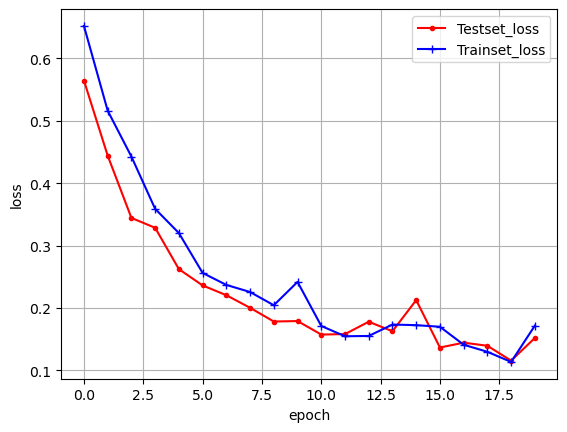

In [9]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='+', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()